In [ ]:
from dotenv import load_dotenv
load_dotenv()

from pprint import pprint

import warnings
warnings.filterwarnings('ignore')

# Langsmith tracing 여부를 확인 (true: langsmith 추적 활성화, false: langsmith 추적 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true


In [ ]:
from langchain_community.utilities import SQLDatabase

# SQLite 데이터베이스 연결
db = SQLDatabase.from_uri("sqlite:///nutrition_data.db")

# 사용 가능한 테이블 목록 출력
tables = db.get_usable_table_names()
print(tables)

columns_result = db.run("SELECT c.name FROM PRAGMA_TABLE_INFO('nutrition_data') c")
print(columns_result)

['nutrition_data']
[('식품군',), ('가식부_100g_당_식품명',), ('출처',), ('일반성분_Proximates_에너지_kcal',), ('일반성분_Proximates_수분_g',), ('일반성분_Proximates_단백질_g',), ('일반성분_Proximates_지방_g',), ('일반성분_Proximates_회분_g',), ('일반성분_Proximates_탄수화물_g',), ('일반성분_Proximates_당류_g',), ('일반성분_Proximates_자당_g',), ('일반성분_Proximates_포도당_g',), ('일반성분_Proximates_과당_g',), ('일반성분_Proximates_유당_g',), ('일반성분_Proximates_맥아당_g',), ('일반성분_Proximates_갈락토오스_g',), ('일반성분_Proximates_총_식이섬유_g',), ('일반성분_Proximates_수용성_식이섬유_g',), ('일반성분_Proximates_불용성_식이섬유_g',), ('무기질_Minerals_칼슘_mg',), ('무기질_Minerals_철_mg',), ('무기질_Minerals_마그네슘_mg',), ('무기질_Minerals_인_mg',), ('무기질_Minerals_칼륨_mg',), ('무기질_Minerals_나트륨_mg',), ('무기질_Minerals_아연_mg',), ('무기질_Minerals_구리_mg',), ('무기질_Minerals_망간_mg',), ('무기질_Minerals_셀레늄_μg',), ('무기질_Minerals_몰리브덴_μg',), ('무기질_Minerals_요오드_μg',), ('비타민_Vitamins_비타민_A_μg',), ('비타민_Vitamins_레티놀_μg',), ('비타민_Vitamins_베타카로틴_μg',), ('비타민_Vitamins_티아민_mg',), ('비타민_Vitamins_리보플라빈_mg',), ('비타민_Vitamins_니아신_mg',), ('비타민_Vitamin

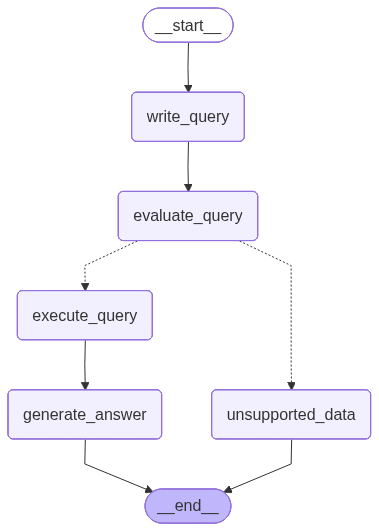

In [ ]:
from typing import Annotated, TypedDict, Literal, List
from langchain_openai import ChatOpenAI
from langchain_community.tools import QuerySQLDatabaseTool
from langgraph.graph import START, END, StateGraph 
from IPython.display import Image, display

from langchain.chains import create_sql_query_chain
from langchain.chains.sql_database.prompt import SQLITE_PROMPT


# 상태 정보를 저장하는 State 클래스
class NutritionState(TypedDict):
    question: str  # 입력 질문
    query: str     # 생성된 쿼리
    score: float   # 쿼리의 정합성 점수(0~1)
    result: str    # 쿼리 결과
    answer: str    # 생성된 답변


# SQL 쿼리 생성 Structured Output
class QueryOutput(TypedDict):
    """Generated SQL query."""
    query: Annotated[str, ..., "Syntactically valid SQL query."]

# 생성된 쿼리를 평가하기 위한 Structured Output    
class EvaluateOutput(TypedDict):
    """Evaluate SQL query."""
    score: float
    columns: List[str]
    
# 모델
llm = ChatOpenAI(model="gpt-4.1-mini")

structured_query_llm = llm.with_structured_output(QueryOutput)
structured_evaluate_llm = llm.with_structured_output(EvaluateOutput)

# SQL 쿼리 생성 chain (최대 10개의 데이터를 가져오는 쿼리 생성)
gpt_sql = create_sql_query_chain(llm=llm, db=db, k=10, prompt=SQLITE_PROMPT)


def write_query(state: NutritionState) -> NutritionState:
    """Generate SQL query to fetch information."""
    prompt = gpt_sql.invoke({"question": state["question"]})
    result = structured_query_llm.invoke(prompt)
    print("write_query: result")
    pprint(result)
    print("-"*100)
    return {"query": result["query"]}

def evaluate_query(state: NutritionState) -> NutritionState:
    """Evaluate SQL query."""
    prompt = f"""
        아래 질문과 쿼리의 정합성에 대해 평가해주세요. 점수(0~1)로만 평가해주고 사용된 컬림 이름을 반환해주세요.

        Question: {state["question"]}
        SQLQuery: {state["query"]}
        """
    result = structured_evaluate_llm.invoke(prompt)
    print("evaluate_query: result")
    pprint(result)
    print("-"*100)

    # 사용된 컬럼 목록이 실제 테이블에 존재하는 컬럼인지 검사
    columns = result["columns"]
    for column in columns:
        if column not in db.get_table_info():
            print(f"사용된 컬럼 {column}이 실제 테이블에 존재하지 않습니다.")
            return {"score": 0}

    return {"score": result["score"]}

def decide_next_step(state: NutritionState) -> Literal["execute_query", "unsupported_data"]:
    """점수가 0.3 이상이면 쿼리 실행, 아니면 지원하지 않는 데이터"""
    if state["score"] > 0.3:
        return "execute_query"
    else:
        return "unsupported_data"

def execute_query(state: NutritionState):
    """SQL쿼리 실행"""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

def generate_answer(state: NutritionState):
    """주어진 질문, 쿼리, 결과를 바탕으로 답변 생성"""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

def unsupported_data(state: NutritionState):
    """지원하지 않는 데이터에 대한 응답"""
    return {"answer": "지원하지 않는 데이터입니다."}

# 상태 그래프 생성
graph_builder = StateGraph(NutritionState)

graph_builder.add_node("write_query", write_query)
graph_builder.add_node("evaluate_query", evaluate_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_answer", generate_answer)
graph_builder.add_node("unsupported_data", unsupported_data)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "evaluate_query")

graph_builder.add_conditional_edges(
    "evaluate_query",
    decide_next_step
)

graph_builder.add_edge("execute_query", "generate_answer")
graph_builder.add_edge("generate_answer", END)

graph = graph_builder.compile()

# 상태 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

In [120]:
# 오타 테스트: '요도드' -> '요오드'
for step in graph.stream(
    {"question": "상위 5개 요도드가 높은 식품은?"}, stream_mode="updates"
):
    print(step)

write_query: result
{'query': 'SELECT "가식부_100g_당_식품명", "무기질_Minerals_요오드_μg" \n'
          'FROM "nutrition_data" \n'
          'WHERE "무기질_Minerals_요오드_μg" IS NOT NULL \n'
          'ORDER BY "무기질_Minerals_요오드_μg" DESC \n'
          'LIMIT 5;'}
----------------------------------------------------------------------------------------------------
{'write_query': {'query': 'SELECT "가식부_100g_당_식품명", "무기질_Minerals_요오드_μg" \nFROM "nutrition_data" \nWHERE "무기질_Minerals_요오드_μg" IS NOT NULL \nORDER BY "무기질_Minerals_요오드_μg" DESC \nLIMIT 5;'}}
evaluate_query: result
{'columns': ['가식부_100g_당_식품명', '무기질_Minerals_요오드_μg'], 'score': 1}
----------------------------------------------------------------------------------------------------
{'evaluate_query': {'score': 1}}
{'execute_query': {'result': "[('하이라이스, 가루', 973.24), ('멸치 육수, 티백, 채소 포함', 912.21), ('명태, 북어, 말린것', 499.14), ('석이버섯, 말린것', 474.78), ('메추리알, 난황, 생것', 331.76)]"}}
{'generate_answer': {'answer': '상위 5개 요오드 함량이 높은 식품은 다음과 같습니다:\n\n1. 하이라이스,

In [121]:
# LLM을 이용한 식품 원료명 추측: '통풍' -> '퓨린'
for step in graph.stream(
    {"question": "통풍에 가장 안좋은 식품은?"}, stream_mode="updates"
):
    print(step)

write_query: result
{'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_푸린_mg" \n'
          'FROM nutrition_data \n'
          'WHERE "일반성분_Proximates_푸린_mg" IS NOT NULL \n'
          'ORDER BY "일반성분_Proximates_푸린_mg" DESC \n'
          'LIMIT 10;'}
----------------------------------------------------------------------------------------------------
{'write_query': {'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_푸린_mg" \nFROM nutrition_data \nWHERE "일반성분_Proximates_푸린_mg" IS NOT NULL \nORDER BY "일반성분_Proximates_푸린_mg" DESC \nLIMIT 10;'}}
evaluate_query: result
{'columns': ['가식부_100g_당_식품명', '일반성분_Proximates_푸린_mg'], 'score': 0.9}
----------------------------------------------------------------------------------------------------
사용된 컬럼 일반성분_Proximates_푸린_mg이 실제 테이블에 존재하지 않습니다.
{'evaluate_query': {'score': 0}}
{'unsupported_data': {'answer': '지원하지 않는 데이터입니다.'}}


In [ ]:
# 데이터에 없는 성분
for step in graph.stream(
    {"question": "퓨린이 가장 많은 식품은?"}, stream_mode="updates"
):
    print(step)

write_query: result
{'query': 'SELECT "가식부_100g_당_식품명", "퓨린_mg" FROM nutrition_data WHERE "퓨린_mg" '
          'IS NOT NULL ORDER BY "퓨린_mg" DESC LIMIT 5;'}
----------------------------------------------------------------------------------------------------
SELECT "가식부_100g_당_식품명", "퓨린_mg" FROM nutrition_data WHERE "퓨린_mg" IS NOT NULL ORDER BY "퓨린_mg" DESC LIMIT 5;
SELECT "가식부_100g_당_식품명", "퓨린_mg" FROM nutrition_data WHERE "퓨린_mg" IS NOT NULL ORDER BY "퓨린_mg" DESC LIMIT 5;
{'write_query': {'query': 'SELECT "가식부_100g_당_식품명", "퓨린_mg" FROM nutrition_data WHERE "퓨린_mg" IS NOT NULL ORDER BY "퓨린_mg" DESC LIMIT 5;'}}
evaluate_query: result
{'columns': ['가식부_100g_당_식품명', '퓨린_mg'], 'score': 0.9}
----------------------------------------------------------------------------------------------------
사용된 컬럼 퓨린_mg이 실제 테이블에 존재하지 않습니다.
{'evaluate_query': {'score': 0}}
{'unsupported_data': {'answer': '지원하지 않는 데이터입니다.'}}


In [ ]:
# 식품명으로 검색
for step in graph.stream(
    {"question": "라면의 당류 함량은?"}, stream_mode="updates"
):
    print(step)

write_query: result
{'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_당류_g" FROM '
          '"nutrition_data" WHERE "가식부_100g_당_식품명" LIKE \'%라면%\' LIMIT 5;'}
----------------------------------------------------------------------------------------------------
SELECT "가식부_100g_당_식품명", "일반성분_Proximates_당류_g" FROM "nutrition_data" WHERE "가식부_100g_당_식품명" LIKE '%라면%' LIMIT 5;
SELECT "가식부_100g_당_식품명", "일반성분_Proximates_당류_g" FROM "nutrition_data" WHERE "가식부_100g_당_식품명" LIKE '%라면%' LIMIT 5;
{'write_query': {'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_당류_g" FROM "nutrition_data" WHERE "가식부_100g_당_식품명" LIKE \'%라면%\' LIMIT 5;'}}
evaluate_query: result
{'columns': ['가식부_100g_당_식품명', '일반성분_Proximates_당류_g'], 'score': 0.9}
----------------------------------------------------------------------------------------------------
{'evaluate_query': {'score': 0.9}}
{'execute_query': {'result': "[('라면, 말린것', 1.1), ('라면, 말린것, 삶은것', 0.31), ('라면, 용기라면, 말린것', 0.53), ('라면, 용기라면, 말린것, 삶은것', 0.06), ('라면 건

In [123]:
# 식품명으로 검색
for step in graph.stream(
    {"question": "짜장라면과 볶음라면의 당류 함량과 에너지 함량은?"}, stream_mode="updates"
):
    print(step)

write_query: result
{'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_당류_g", '
          '"일반성분_Proximates_에너지_kcal" FROM "nutrition_data" WHERE '
          '"가식부_100g_당_식품명" LIKE \'%짜장라면%\' OR "가식부_100g_당_식품명" LIKE '
          "'%볶음라면%' LIMIT 10;"}
----------------------------------------------------------------------------------------------------
{'write_query': {'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_당류_g", "일반성분_Proximates_에너지_kcal" FROM "nutrition_data" WHERE "가식부_100g_당_식품명" LIKE \'%짜장라면%\' OR "가식부_100g_당_식품명" LIKE \'%볶음라면%\' LIMIT 10;'}}
evaluate_query: result
{'columns': ['가식부_100g_당_식품명',
             '일반성분_Proximates_당류_g',
             '일반성분_Proximates_에너지_kcal'],
 'score': 1}
----------------------------------------------------------------------------------------------------
{'evaluate_query': {'score': 1}}
{'execute_query': {'result': "[('라면 건더기 스프, 짜장라면', 31.17, 360.0), ('라면 스프, 짜장라면', 21.71, 350.0), ('라면 스프, 짜장라면, 조미유', 0.0, 899.0), ('라면, 짜장라면, 조리전', 4.49

In [126]:
for step in graph.stream(
    {"question": "조리가공식품 중 칼로리가 제일높은 5개는?"}, stream_mode="updates"
):
    print(step)

write_query: result
{'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_에너지_kcal" FROM '
          'nutrition_data WHERE "식품군" LIKE \'%조리가공식품%\' ORDER BY '
          '"일반성분_Proximates_에너지_kcal" DESC LIMIT 5;'}
----------------------------------------------------------------------------------------------------
{'write_query': {'query': 'SELECT "가식부_100g_당_식품명", "일반성분_Proximates_에너지_kcal" FROM nutrition_data WHERE "식품군" LIKE \'%조리가공식품%\' ORDER BY "일반성분_Proximates_에너지_kcal" DESC LIMIT 5;'}}
evaluate_query: result
{'columns': ['가식부_100g_당_식품명', '일반성분_Proximates_에너지_kcal'], 'score': 0.9}
----------------------------------------------------------------------------------------------------
{'evaluate_query': {'score': 0.9}}
{'execute_query': {'result': "[('스프, 크림 스프, 가루', 430.0), ('라면, 짜장라면, 조리전', 428.0), ('라면, 용기라면, 조리전', 425.0), ('스프, 옥수수 스프, 가루', 420.0), ('라면, 조리전', 416.0)]"}}
{'generate_answer': {'answer': '조리가공식품 중 칼로리가 제일 높은 5개는 다음과 같습니다:\n\n1. 스프, 크림 스프, 가루 - 430 kcal  \n2. 라면, 짜장라면, 조